In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import zipfile


zip_path = './drive/MyDrive/data.zip'
dest_dir = './data'

if os.path.exists(dest_dir) and os.path.isdir(dest_dir) and len(os.listdir(dest_dir)) > 0:
    print(f"'{dest_dir}' уже существует и не пустая, извлечение не требуется.")
else:
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir, exist_ok=True)
    print(f"Извлекаем '{zip_path}' в папку '{dest_dir}'")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

file_count = sum(len(files) for _, _, files in os.walk(dest_dir))
print(f"Всего файлов в '{dest_dir}': {file_count}")


Извлекаем './drive/MyDrive/data.zip' в папку './data'
Всего файлов в './data': 225312


## ГЕНЕРАЦИЯ НАБОРА ДАННЫХ

In [4]:
import os
import random
import cv2
import numpy as np

characters = [")","(","+","-",",","0","1","2","3","4","5","6","7","8","9","X","h","t","*","w","y"]

def generate_string(length):
    return ''.join(random.choice(characters) for _ in range(length))

def images_from_string(string):
    images = []

    for ch in string:
        folder_name = ch

        if ch == '*':
            folder_name = 'times'

        folder_path = os.path.join(dest_dir, folder_name)

        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        random_file = random.choice(files)
        images.append(os.path.join(folder_path, random_file))

    return images

def combine_images(image_paths, spacing=0):
    images = [cv2.imread(path) for path in image_paths]

    if not images:
        return None

    if spacing > 0:
      for i in range(len(images)-1):
          spacer = np.zeros((images[i].shape[0], spacing, 3), dtype=np.uint8)
          spacer[:] = (255, 255, 255)
          images.insert(i*2 + 1, spacer)

    combined_img = cv2.cvtColor(cv2.hconcat(images), cv2.COLOR_BGR2RGB)
    return combined_img

Сгенерированная строка: 743w22h5**
Выбранные изображения из датасета:
./data/7/7_56517.jpg
./data/4/exp106216.jpg
./data/3/exp3599.jpg
./data/w/exp66688.jpg
./data/2/exp686.jpg
./data/2/exp76773.jpg
./data/h/exp64163.jpg
./data/5/exp44018.jpg
./data/times/times_62173.jpg
./data/times/exp44856.jpg


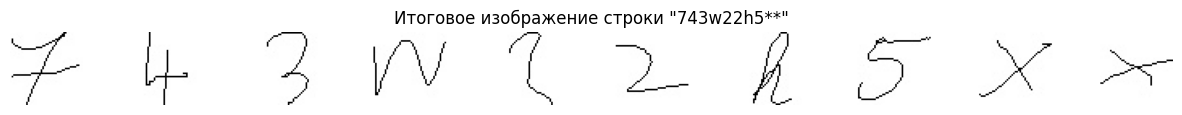

In [5]:
import matplotlib.pyplot as plt

str_size = 10

random_str = generate_string(str_size)
print(f"Сгенерированная строка: {random_str}")

image_paths = images_from_string(random_str)
print(f"Выбранные изображения из датасета:")
for path in image_paths:
    print(path)

str_image = combine_images(image_paths, spacing=30)

plt.figure(figsize=(15, 2))
plt.imshow(str_image)
plt.axis('off')
plt.title(f'Итоговое изображение строки "{random_str}"')
plt.show()

In [6]:
def normalize_symbol(symbol, size=45):
    h, w = symbol.shape
    img_resized = np.ones((size, size), dtype=np.uint8) * 255
    y_offset = (size - h) // 2
    x_offset = (size - w) // 2
    img_resized[y_offset:y_offset+h, x_offset:x_offset+w] = symbol

    img_resized = cv2.bitwise_not(img_resized)
    return img_resized

def extract_symbols(image, size=45, threshold=10):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    symbols = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h > threshold:
            symbol = gray[y:y+h, x:x+w]
            symbol_normalized = normalize_symbol(symbol, size)
            symbols.append(symbol_normalized)

    return symbols

Кол-во символов: 10


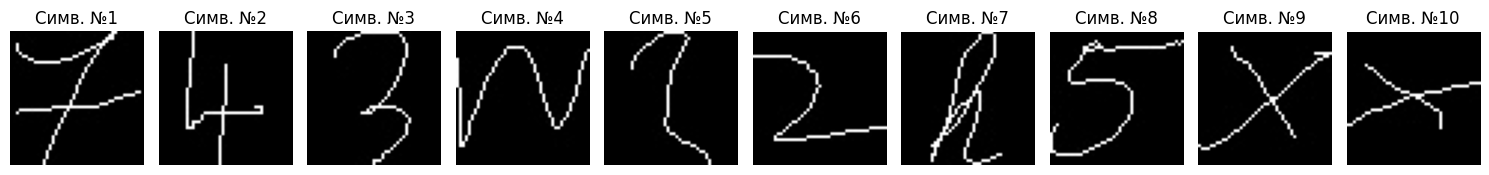

In [7]:
symbols = extract_symbols(str_image)
print(f"Кол-во символов: {len(symbols)}")

plt.figure(figsize=(15, 2))

for i, symbol in enumerate(symbols):
      plt.subplot(1, 10, i+1)
      plt.imshow(symbol, cmap='gray')
      plt.title(f'Симв. №{i+1}')
      plt.axis('off')

plt.tight_layout()
plt.show()

## КЛАССИФИКАЦИЯ (k ближайших соседей)

In [8]:
def load_data():
    X, y = [], []
    for symbol in characters:
        folder_name = 'times' if symbol == '*' else symbol
        folder_path = os.path.join(dest_dir, folder_name)

        if not os.path.exists(folder_path):
            continue

        images = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        print(f"Символ '{symbol}': {len(images)} образцов")

        for img_name in images:
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is not None:
                img_normalized = normalize_symbol(img)
                X.append(img_normalized.flatten())
                y.append(symbol)

    return np.array(X), np.array(y)

In [9]:
from sklearn.model_selection import train_test_split

X_all, y_all = load_data()
print(f"Всего загружено {len(X_all)} образцов")

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.1, shuffle=True, stratify=y_all
)

print(f"Тренировочные данные: {len(X_train)} образцов")
print(f"Тестовые данные: {len(X_test)} образцов")

Символ ')': 14355 образцов
Символ '(': 14294 образцов
Символ '+': 25112 образцов
Символ '-': 33997 образцов
Символ ',': 1906 образцов
Символ '0': 6914 образцов
Символ '1': 26520 образцов
Символ '2': 26141 образцов
Символ '3': 10909 образцов
Символ '4': 7396 образцов
Символ '5': 3545 образцов
Символ '6': 3118 образцов
Символ '7': 2909 образцов
Символ '8': 3068 образцов
Символ '9': 628 образцов
Символ 'X': 26594 образцов
Символ 'h': 1464 образцов
Символ 't': 3274 образцов
Символ '*': 3251 образцов
Символ 'w': 556 образцов
Символ 'y': 9340 образцов
Всего загружено 225291 образцов
Тренировочные данные: 202761 образцов
Тестовые данные: 22530 образцов


In [10]:
from cuml.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all)

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X_all, y_all_encoded, test_size=0.1, shuffle=True, stratify=y_all_encoded
)

models = {}
test_accuracies = {}

for k in [1, 3, 5, 7]:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train_encoded)
    print(f"KNN (k={k}) обучен")

    y_pred_encoded = model.predict(X_test)
    accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
    test_accuracies[k] = accuracy

    models[k] = model
    print(f"KNN (k={k}): точность = {accuracy:.1%}")

best_k = max(test_accuracies, key=test_accuracies.get)
best_model = models[best_k]
print(f"Лучший классификатор: KNN (k={best_k}) (точность: {test_accuracies[best_k]:.1%})")

KNN (k=1) обучен
KNN (k=1): точность = 99.5%
KNN (k=3) обучен
KNN (k=3): точность = 95.5%
KNN (k=5) обучен
KNN (k=5): точность = 80.5%
KNN (k=7) обучен
KNN (k=7): точность = 74.8%
Лучший классификатор: KNN (k=1) (точность: 99.5%)


## РАСПОЗНАВАНИЕ

Тестирование на 10 последовательностях...

Последовательность 1:
  Оригинал:    h0,71143)X
  Распознано:  h0,71143)X
  Точность:    100.0% (10/10 символов)

Последовательность 2:
  Оригинал:    74)01w23wy
  Распознано:  74)01w23wy
  Точность:    100.0% (10/10 символов)

Последовательность 3:
  Оригинал:    y8X,,t77h6
  Распознано:  y8X,,t77h6
  Точность:    100.0% (10/10 символов)

Последовательность 4:
  Оригинал:    3y6w)1+),0
  Распознано:  3y6w)1+),0
  Точность:    100.0% (10/10 символов)

Последовательность 5:
  Оригинал:    y42tX1hh3X (длина: 10)
  Распознано:  y42t)(1hh3X (длина: 11)
  ⚠️  ВНИМАНИЕ: Несоответствие количества символов!
  Точность (по 10 символам): 50.0% (5/10 символов)

Последовательность 6:
  Оригинал:    +w90+69140
  Распознано:  +w(0+69140
  Точность:    90.0% (9/10 символов)

Последовательность 7:
  Оригинал:    568-2y-0)t
  Распознано:  568-2y-0)t
  Точность:    100.0% (10/10 символов)

Последовательность 8:
  Оригинал:    hh(,745w62
  Распознано:  hh(,)45w6

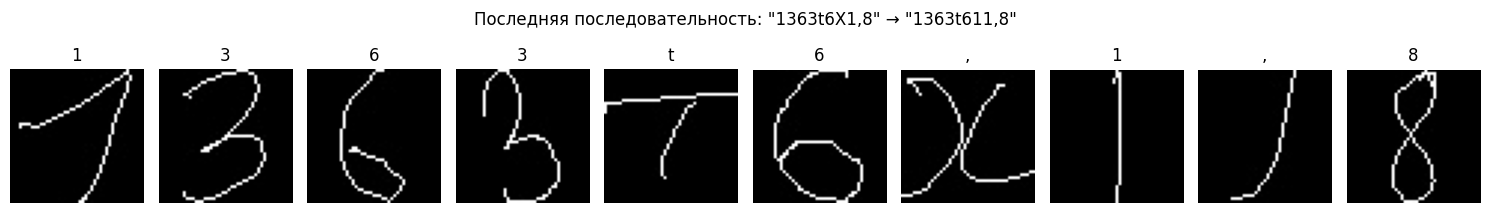

In [12]:
from sklearn.metrics import classification_report

def predict_symbols(model, symbols):
    recognized_chars = []
    for symbol in symbols:
        predicted_encoded_char = model.predict(symbol.flatten().reshape(1, -1))[0]
        predicted_char = label_encoder.inverse_transform([predicted_encoded_char])[0]
        recognized_chars.append(predicted_char)
    return recognized_chars

# Тестирование на нескольких последовательностях
num_sequences = 10
str_size = 10

all_original_chars = []
all_recognized_chars = []
all_sequences_info = []

print(f"Тестирование на {num_sequences} последовательностях...\n")

for seq_idx in range(num_sequences):
    # Генерация новой последовательности
    original_str = generate_string(str_size)
    image_paths = images_from_string(original_str)
    str_image = combine_images(image_paths, spacing=30)
    symbols = extract_symbols(str_image)

    # Распознавание
    recognized_chars = predict_symbols(best_model, symbols)
    recognized_str = ''.join(recognized_chars)

    # Проверка соответствия количества символов
    min_len = min(len(original_str), len(recognized_chars))

    # Обрезка до минимальной длины для корректного сравнения
    original_chars_trimmed = list(original_str)[:min_len]
    recognized_chars_trimmed = recognized_chars[:min_len]

    # Сохранение результатов
    all_original_chars.extend(original_chars_trimmed)
    all_recognized_chars.extend(recognized_chars_trimmed)

    correct_count = sum(1 for o, r in zip(original_chars_trimmed, recognized_chars_trimmed) if o == r)
    all_sequences_info.append({
        'original': original_str,
        'recognized': recognized_str,
        'correct': correct_count,
        'total': min_len,
        'original_len': len(original_str),
        'recognized_len': len(recognized_chars)
    })

    # Вывод информации о каждой последовательности
    if len(original_str) != len(recognized_chars):
        print(f"Последовательность {seq_idx + 1}:")
        print(f"  Оригинал:    {original_str} (длина: {len(original_str)})")
        print(f"  Распознано:  {recognized_str} (длина: {len(recognized_chars)})")
        print(f"  ⚠️  ВНИМАНИЕ: Несоответствие количества символов!")
        print(f"  Точность (по {min_len} символам): {correct_count/min_len:.1%} ({correct_count}/{min_len} символов)")
    else:
        seq_accuracy = accuracy_score(original_chars_trimmed, recognized_chars_trimmed)
        print(f"Последовательность {seq_idx + 1}:")
        print(f"  Оригинал:    {original_str}")
        print(f"  Распознано:  {recognized_str}")
        print(f"  Точность:    {seq_accuracy:.1%} ({correct_count}/{min_len} символов)")
    print()

# Общая статистика
print("=" * 60)
print("ОБЩАЯ СТАТИСТИКА:")
print("=" * 60)
print(f"\nВсего последовательностей: {num_sequences}")
print(f"Всего символов: {len(all_original_chars)}")

overall_accuracy = accuracy_score(all_original_chars, all_recognized_chars)
total_correct = sum(1 for o, r in zip(all_original_chars, all_recognized_chars) if o == r)
print(f"Общая точность: {overall_accuracy:.1%} ({total_correct}/{len(all_original_chars)} символов)")

# Точность по последовательностям
sequence_accuracies = [info['correct'] / info['total'] for info in all_sequences_info]
print(f"Средняя точность по последовательностям: {np.mean(sequence_accuracies):.1%}")
print(f"Минимальная точность: {np.min(sequence_accuracies):.1%}")
print(f"Максимальная точность: {np.max(sequence_accuracies):.1%}")

# Classification report для всех символов
print("\n" + "=" * 60)
print("ДЕТАЛЬНЫЙ ОТЧЕТ:")
print("=" * 60)
print(classification_report(all_original_chars, all_recognized_chars, zero_division=0))

# Визуализация последней последовательности
if all_sequences_info:
    last_seq = all_sequences_info[-1]
    last_original = last_seq['original']
    last_image_paths = images_from_string(last_original)
    last_str_image = combine_images(last_image_paths, spacing=30)
    last_symbols = extract_symbols(last_str_image)
    last_recognized = predict_symbols(best_model, last_symbols)

    plt.figure(figsize=(15, 2))
    for i, symbol in enumerate(last_symbols):
        plt.subplot(1, len(last_symbols), i+1)
        plt.imshow(symbol, cmap='gray')
        plt.title(f'{last_recognized[i]}')
        plt.axis('off')
    plt.suptitle(f'Последняя последовательность: "{last_original}" → "{last_seq["recognized"]}"', y=1.05)
    plt.tight_layout()
    plt.show()